In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import layers

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("darkgrid")
%matplotlib inline

from functools import partial

In [3]:
sess = tf.InteractiveSession()

## Gumbel-Softmax sampling

In [4]:
def sample_gumbel(shape, eps=1e-20): 
    """Sample from Gumbel(0, 1)"""
    U = tf.random_uniform(shape,minval=0,maxval=1)
    return -tf.log(-tf.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature): 
    """ Draw a sample from the Gumbel-Softmax distribution"""
    y = logits + sample_gumbel(tf.shape(logits))
    return tf.nn.softmax(y / temperature)

## The core model

In [44]:
NUM_SUITS = 2
NUM_NUMBERS = 5

HIDDEN_DIM = 128
VOCAB_SIZE = NUM_SUITS * NUM_NUMBERS
NUM_CLASSES = NUM_SUITS * NUM_NUMBERS

def build_graph(card_suit, card_number, sample_type="gumbel-sf"):
    temperature = tf.constant(1.0)

    # Agent 1 reads card and makes an utterance.
    a1_hidden = layers.fully_connected(tf.concat(1, [card_suit, card_number]),
                                       HIDDEN_DIM)
    a1_logits = layers.fully_connected(a1_hidden,
                                       VOCAB_SIZE, activation_fn=None,
                                       biases_initializer=None)
    
    if sample_type == "gumbel-sf":
        a1_sample_dense = None
        a1_sample = gumbel_softmax_sample(a1_logits, temperature)
    elif sample_type == "sf":
        a1_sample_dense = None
        a1_sample = tf.nn.softmax(a1_logits / temperature)
    elif sample_type == "multinomial":
        a1_sample_dense = tf.multinomial(a1_logits / temperature, 1)
        a1_sample = tf.one_hot(tf.squeeze(a1_sample_dense, [1]), VOCAB_SIZE)
    else:
        raise ValueError("unknown sample_type %s" % sample_type)

    # Agent 2 reads utterance and makes a selection.
    a2_hidden = layers.fully_connected(a1_sample, HIDDEN_DIM)
    a2_logits = layers.fully_connected(a2_hidden, NUM_CLASSES, 
                                       activation_fn=None,
                                       biases_initializer=None)
    
    return temperature, a1_logits, a1_sample_dense, a2_logits

## Training graphs

In [38]:
def make_inputs():
    card_suit = tf.placeholder(tf.float32, shape=(None, NUM_SUITS))
    card_number = tf.placeholder(tf.float32, shape=(None, NUM_NUMBERS))
    targets = tf.placeholder(tf.int32, shape=(None,))
    return card_suit, card_number, targets

In [39]:
def build_differentiable_model(learning_rate, sample_type="gumbel-sf"):
    """
    Build a model which samples in a differentiable manner and learns
    via backpropagation on cross-entropy loss.
    """
    card_suit, card_number, targets = make_inputs()
    temperature, _, _, logits = build_graph(card_suit, card_number, sample_type)
    
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, targets)
    loss = tf.reduce_mean(loss)
    
    opt = tf.train.MomentumOptimizer(learning_rate, 0.9)
    train_op = opt.minimize(loss)
    
    return (card_suit, card_number, targets, temperature), (train_op, loss)

In [56]:
def build_score_function_model(learning_rate):
    """
    Build a model which samples in a non-differentiable manner and learns
    via score-function gradient estimates.
    """
    card_suit, card_number, targets = make_inputs()
    temperature, a1_logits, a1_sample, a2_logits = build_graph(
        card_suit, card_number, "multinomial")
    
    batch_size = tf.shape(a1_logits)[0]
    
    # For each example, retrieve p(correct_class)
    p_class = tf.nn.softmax(a2_logits)
    p_class = tf.reshape(p_class, (-1,))
    p_class_indices = targets + tf.range(batch_size) * NUM_CLASSES
    p_correct_class = tf.gather(p_class, p_class_indices)
    avg_reward = tf.reduce_mean(p_correct_class)
    
    # For each example, retrieve p(sampled_token)
    log_p_vocab = tf.nn.log_softmax(a1_logits)
    log_p_vocab = tf.reshape(log_p_vocab, (-1,))
    vocab_indices = tf.to_int32(a1_sample) + tf.range(batch_size) * VOCAB_SIZE
    log_p_sampled_vocab = tf.gather(log_p_vocab, vocab_indices)
    
    # Multiply and calculate mean before calling tf.gradients.
    # But functionally the same, since p(correct_class) doesn't
    # depend on a1's parameters.
    objective = -(log_p_sampled_vocab * p_correct_class)
    objective = tf.reduce_mean(objective)
    
    opt = tf.train.MomentumOptimizer(learning_rate, 0.9)
    train_op = opt.minimize(objective)
    
    inputs = (card_suit, card_number, targets, temperature)
    outputs = (train_op, -avg_reward)
    
    return inputs, outputs

## Training code

In [41]:
def yield_batches(batch_size):
    n_cards = NUM_SUITS * NUM_NUMBERS
    while True:
        cards = np.random.choice(n_cards, size=batch_size, 
                                 replace=not batch_size < n_cards)
        
        suits = np.floor_divide(cards, NUM_NUMBERS)
        numbers = np.mod(cards, NUM_NUMBERS)
        
        input_suits = np.zeros((batch_size, NUM_SUITS))
        input_numbers = np.zeros((batch_size, NUM_NUMBERS))
        
        batch_range = np.arange(batch_size)
        input_suits[batch_range, suits] = 1
        input_numbers[batch_range, numbers] = 1
        
        yield input_suits, input_numbers, cards

In [42]:
def test_model(build_fn, batch_size, n_iterations, learning_rate):
    tf.reset_default_graph()
    sess = tf.InteractiveSession()
    
    inputs, outputs = build_fn(learning_rate)
    sess.run(tf.global_variables_initializer())
    
    card_suit, card_number, targets, temperature = inputs
    train_op, loss = outputs
    
    losses = []
    for t, batch_data in zip(range(n_iterations),
                             yield_batches(batch_size)):
        b_suits, b_numbers, b_targets = batch_data

        b_temperature = 2.0 * np.exp(-1e-4 * t)
        feed = {card_suit: b_suits, card_number: b_numbers,
                targets: b_targets, temperature: b_temperature}
        _, b_loss = sess.run([train_op, loss], feed)

        losses.append(b_loss)
        
    return losses

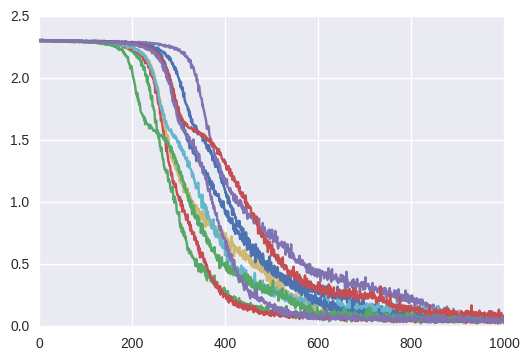

In [49]:
build_gumbel_model = partial(build_differentiable_model, sample_type="gumbel-sf")

all_gsf_losses = []
for _ in range(10):
    lr = np.random.uniform(low=0.04, high=0.06)
    all_gsf_losses.append(test_model(build_gumbel_model, 256, 1000, lr))
    
for losses in all_gsf_losses:
    plt.plot(losses)

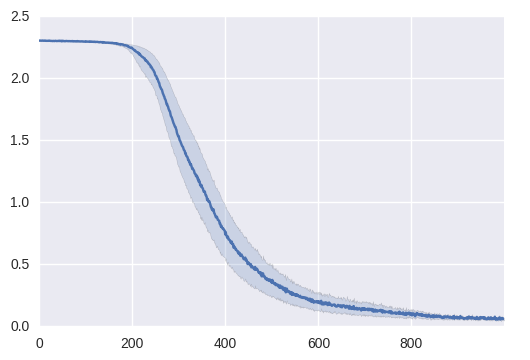

In [50]:
sns.tsplot(all_gsf_losses, ci=95)

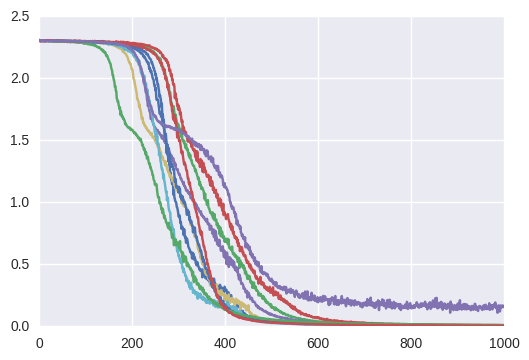

In [47]:
build_softmax_model = partial(build_differentiable_model, sample_type="sf")

all_smx_losses = []
for _ in range(10):
    lr = np.random.uniform(low=0.04, high=0.06)
    all_smx_losses.append(test_model(build_softmax_model, 256, 1000, lr))
    
for losses in all_smx_losses:
    plt.plot(losses)

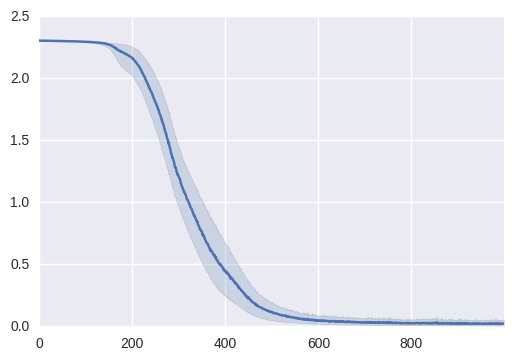

In [48]:
sns.tsplot(all_smx_losses, ci=95)

/u/nlp/packages/anaconda3/envs/jon-common/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


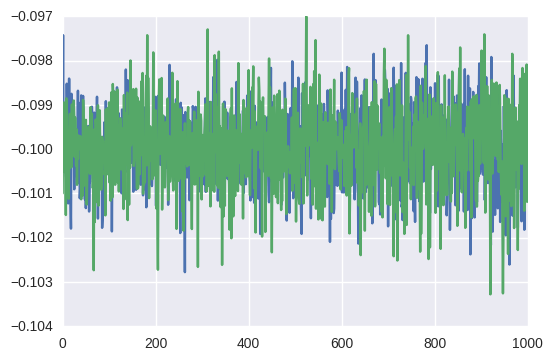

In [57]:
all_sf_losses = []
for _ in range(2):
    lr = np.random.uniform(low=0.04, high=0.06)
    all_sf_losses.append(test_model(build_score_function_model, 256, 1000, 0.05))
    
for losses in all_sf_losses:
    plt.plot(losses)

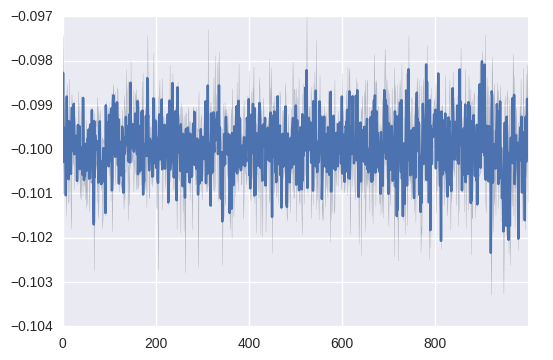

In [58]:
sns.tsplot(all_sf_losses, ci=95)